In [1]:
from google.colab import drive
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, classification_report
)

# --- Mount Google Drive ---
drive.mount('/content/drive')

project_path = "/content/drive/MyDrive/Heart_Disease_Project"
data_path = os.path.join(project_path, "data")
os.makedirs(data_path, exist_ok=True)

# --- Load reduced dataset (from feature selection) ---
df = pd.read_csv(os.path.join(data_path, "selected_features_heart.csv"))
X = df.drop("target", axis=1)
y = df["target"]

Mounted at /content/drive


In [2]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set:", X_train.shape, "Testing set:", X_test.shape)


Training set: (242, 7) Testing set: (61, 7)


In [3]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver="liblinear"),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}


trained_models = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    trained_models[name] = model
    print(f"Trained {name}")


Trained Logistic Regression
Trained Decision Tree
Trained Random Forest
Trained SVM


In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

results = []

for model_name, model in models.items():
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
    rec = recall_score(y_test, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)

    results.append({
        "Model": model_name,
        "Accuracy": acc,
        "Precision (macro)": prec,
        "Recall (macro)": rec,
        "F1-score (macro)": f1
    })

import pandas as pd
metrics_df = pd.DataFrame(results)
display(metrics_df)


,Model,Accuracy,Precision (macro),Recall (macro),F1-score (macro)
0,Logistic Regression,0.639344,0.345556,0.361039,0.333333
1,Decision Tree,0.491803,0.259821,0.263203,0.261258
2,Random Forest,0.573770,0.231169,0.258874,0.239250
3,SVM,0.540984,0.231190,0.257143,0.241882


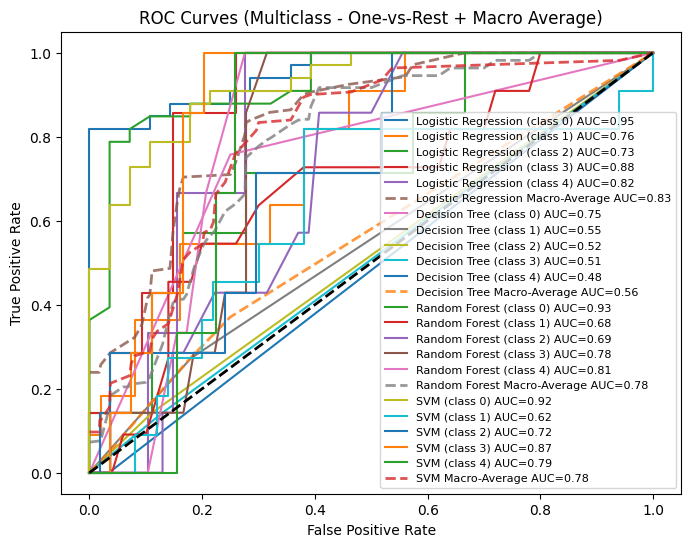


 Macro-Average AUC per model:


,Macro AUC
Logistic Regression,0.829481
Decision Tree,0.561079
Random Forest,0.778563
SVM,0.784604


In [10]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Binarize the output for multiclass ROC
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

auc_summary = {}

plt.figure(figsize=(8,6))

for model_name, model in models.items():
    # Get predicted probabilities or decision scores
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
    else:
        y_score = model.decision_function(X_test)

    # Store per-class AUCs
    per_class_auc = []

    # Compute ROC curve and AUC for each class
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        per_class_auc.append(roc_auc)
        plt.plot(fpr, tpr, lw=1.5,
                 label=f'{model_name} (class {classes[i]}) AUC={roc_auc:.2f}')

    # Compute macro-average AUC
    macro_auc = np.mean(per_class_auc)
    auc_summary[model_name] = macro_auc

    # Compute macro-average ROC curve
    all_fpr = np.unique(np.concatenate([roc_curve(y_test_bin[:, i], y_score[:, i])[0] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        mean_tpr += np.interp(all_fpr, fpr, tpr)
    mean_tpr /= n_classes
    plt.plot(all_fpr, mean_tpr, linestyle="--", lw=2,
             label=f'{model_name} Macro-Average AUC={macro_auc:.2f}', alpha=0.8)

# Plot formatting
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Multiclass - One-vs-Rest + Macro Average)")
plt.legend(loc="lower right", fontsize=8)
plt.show()

# Show AUC summary table
auc_df = pd.DataFrame.from_dict(auc_summary, orient="index", columns=["Macro AUC"])
print("\n Macro-Average AUC per model:")
display(auc_df)
